<h1>Performance Analysis and Player Evaluation in Professional Football using Pyspark </h1>

In [1]:
import pandas as pd 
from pyspark.sql import SparkSession
from pyspark.sql.functions import mean,col, count, when,sum,avg,stddev, max, min

In [2]:
spark = SparkSession.builder.appName("FootballAnalytics").getOrCreate()

In [3]:
df = spark.read.csv(r"C:\Users\ayv44\OneDrive\Desktop\jupyter notebook\dataset\dataset.csv", header=True, inferSchema=True)

In [102]:
df.printSchema()
#df.summary().show()

root
 |-- Name: string (nullable = true)
 |-- Jersey Number: integer (nullable = true)
 |-- Club: string (nullable = true)
 |-- Position: string (nullable = false)
 |-- Nationality: string (nullable = false)
 |-- Age: integer (nullable = true)
 |-- Appearances: integer (nullable = true)
 |-- Wins: integer (nullable = true)
 |-- Losses: integer (nullable = true)
 |-- Goals: integer (nullable = true)
 |-- Goals per match: double (nullable = true)
 |-- Headed goals: integer (nullable = true)
 |-- Goals with right foot: integer (nullable = true)
 |-- Goals with left foot: integer (nullable = true)
 |-- Penalties scored: integer (nullable = true)
 |-- Freekicks scored: integer (nullable = true)
 |-- Shots: integer (nullable = true)
 |-- Shots on target: integer (nullable = true)
 |-- Shooting accuracy %: string (nullable = true)
 |-- Hit woodwork: integer (nullable = true)
 |-- Big chances missed: integer (nullable = true)
 |-- Clean sheets: integer (nullable = true)
 |-- Goals conceded: in

In [5]:
numeric_columns = ['Age', 'Appearances', 'Goals', 'Assists']
mean_values = {col: df.select(mean(df[col])).collect()[0][0] for col in numeric_columns}

In [6]:
print(mean_values)

{'Age': 25.789473684210527, 'Appearances': 68.8231173380035, 'Goals': 7.327495621716287, 'Assists': 5.285464098073555}


In [7]:
df = df.na.fill(mean_values)

In [103]:
#df.show()

In [9]:
common_position = df.groupBy('Position').count().orderBy('count', ascending=False).first()['Position']
common_nationality = df.groupBy('Nationality').count().orderBy('count', ascending=False).first()['Nationality']

df = df.na.fill({
    'Position': common_position,
    'Nationality': common_nationality
})

In [10]:
print("Count of NULLs in Position:", df.filter(df['Position'].isNull()).count())
print("Count of NULLs in Nationality:", df.filter(df['Nationality'].isNull()).count())
# No NULL values -> filling was successful.

Count of NULLs in Position: 0
Count of NULLs in Nationality: 0


In [11]:
print("Checking for unusual values in Age:")
df.select('Age').describe().show()

print("Checking for unusual values in Appearances:")
df.select('Appearances').describe().show()

print("Data types after filling missing values:")
df.printSchema()


Checking for unusual values in Age:
+-------+------------------+
|summary|               Age|
+-------+------------------+
|  count|               571|
|   mean|25.788091068301227|
| stddev| 4.373636934382791|
|    min|                17|
|    max|                38|
+-------+------------------+

Checking for unusual values in Appearances:
+-------+-----------------+
|summary|      Appearances|
+-------+-----------------+
|  count|              571|
|   mean| 68.8231173380035|
| stddev|81.79751567079694|
|    min|                0|
|    max|              539|
+-------+-----------------+

Data types after filling missing values:
root
 |-- Name: string (nullable = true)
 |-- Jersey Number: integer (nullable = true)
 |-- Club: string (nullable = true)
 |-- Position: string (nullable = false)
 |-- Nationality: string (nullable = false)
 |-- Age: integer (nullable = true)
 |-- Appearances: integer (nullable = true)
 |-- Wins: integer (nullable = true)
 |-- Losses: integer (nullable = true)


In [104]:
#print("Summary statistics:")
#df.summary().show()

In [13]:
print("Value counts for Position column:")
df.groupBy('Position').count().show()

Value counts for Position column:
+----------+-----+
|  Position|count|
+----------+-----+
|  Defender|  194|
|Goalkeeper|   69|
|   Forward|  110|
|Midfielder|  198|
+----------+-----+



In [14]:
print("Value counts for Nationality column:")
df.groupBy('Nationality').count().show()

Value counts for Nationality column:
+--------------------+-----+
|         Nationality|count|
+--------------------+-----+
|            Paraguay|    2|
|             Senegal|    3|
|              Sweden|    4|
|              Turkey|    3|
|             Germany|   12|
|              France|   30|
|              Greece|    2|
|             Algeria|    3|
|            Slovakia|    2|
|Saint Kitts And N...|    1|
|           Argentina|   13|
|               Wales|   13|
|             Belgium|   13|
|             Ecuador|    1|
|               Ghana|    5|
|       United States|    6|
|             Croatia|    3|
|             Nigeria|    6|
|               Gabon|    2|
|               Italy|    5|
+--------------------+-----+
only showing top 20 rows



In [105]:
#df.show()

<h1>ANALYSIS START</h1>

In [16]:
player_performance_agg = df.groupBy("Name", "Club", "Position").agg(
    sum("Goals").alias("Total Goals"),
    sum("Assists").alias("Total Assists"),
    sum("Wins").alias("Total Wins"),
    sum("Losses").alias("Total Losses"),
    avg("Goals").alias("Average Goals"),
    avg("Assists").alias("Average Assists"),
    avg("Wins").alias("Average Wins"),
    avg("Losses").alias("Average Losses")
)

In [17]:
player_performance_agg.show(truncate=False)

+-------------------+------------------------+----------+-----------+-------------+----------+------------+-------------+---------------+------------+--------------+
|Name               |Club                    |Position  |Total Goals|Total Assists|Total Wins|Total Losses|Average Goals|Average Assists|Average Wins|Average Losses|
+-------------------+------------------------+----------+-----------+-------------+----------+------------+-------------+---------------+------------+--------------+
|Ahmed El Mohamady  |Aston-Villa             |Defender  |6          |13           |48        |91          |6.0          |13.0           |48.0        |91.0          |
|Jimmy Dunne        |Burnley                 |Defender  |1          |0            |0         |1           |1.0          |0.0            |0.0         |1.0           |
|Nampalys Mendy     |Leicester-City          |Midfielder|0          |0            |20        |16          |0.0          |0.0            |20.0        |16.0          |
|Ben

Aggregated Data: The data is grouped by player name, club, and position, showing total and average performance metrics.

Metrics Included: Goals, assists, wins, and losses are included, providing a comprehensive view of each player's contribution to their team.

<h2>PLAYER PERFORMANCE ANALYSIS</h2>

In [18]:
stats = player_performance_agg.select(
    mean('Total Goals').alias('Mean Total Goals'),
    stddev('Total Goals').alias('Stddev Total Goals'),
    max('Total Goals').alias('Max Total Goals'),
    min('Total Goals').alias('Min Total Goals'),
    mean('Total Assists').alias('Mean Total Assists'),
    stddev('Total Assists').alias('Stddev Total Assists'),
    max('Total Assists').alias('Max Total Assists'),
    min('Total Assists').alias('Min Total Assists'),
    mean('Total Wins').alias('Mean Total Wins'),
    stddev('Total Wins').alias('Stddev Total Wins'),
    max('Total Wins').alias('Max Total Wins'),
    min('Total Wins').alias('Min Total Wins'),
    mean('Total Losses').alias('Mean Total Losses'),
    stddev('Total Losses').alias('Stddev Total Losses'),
    max('Total Losses').alias('Max Total Losses'),
    min('Total Losses').alias('Min Total Losses')
)

stats.show(truncate=False)


+-----------------+------------------+---------------+---------------+------------------+--------------------+-----------------+-----------------+-----------------+-----------------+--------------+--------------+------------------+-------------------+----------------+----------------+
|Mean Total Goals |Stddev Total Goals|Max Total Goals|Min Total Goals|Mean Total Assists|Stddev Total Assists|Max Total Assists|Min Total Assists|Mean Total Wins  |Stddev Total Wins|Max Total Wins|Min Total Wins|Mean Total Losses |Stddev Total Losses|Max Total Losses|Min Total Losses|
+-----------------+------------------+---------------+---------------+------------------+--------------------+-----------------+-----------------+-----------------+-----------------+--------------+--------------+------------------+-------------------+----------------+----------------+
|7.327495621716287|16.810489536415297|180            |0              |5.285464098073555 |9.761764773582767   |84               |0             

<h3>Total Goals:</h3>
Average no of goals scored by players is approximately 7.33.

Standard Deviation: 16.81. Indicates that there is considerable diversity in goal-scoring performance across players.

Max and Min: The maximum number of goals scored by a player is 180, while the minimum is 0.

<h3>Total Assists:</h3> 
The average no of assists provided by players is around 5.29.

Standard Deviation: 9.76.

Max and Min: The maximum number of assists by a player is 84, while the minimum is 0.

<h3>Total Wins:</h3>
On average, players are associated with around 29 total wins.            

Standard Deviation:38.97, indicates variability in the no of wins among players.

Max and Min: The maximum number of wins attributed to a player is 272, while the minimum is 0.

<h3>Total Losses:</h3>

Players have an average of approximately 23.90 total losses.

Standard Deviation: 28.49

Max and Min: The maximum number of losses is 158, and the minimum is 0.

In [19]:
top_performers = player_performance_agg.orderBy('Total Goals', ascending=False).limit(10)
underperformers = player_performance_agg.orderBy('Total Goals').limit(10)

In [20]:
print("Top Performers based on Total Goals:")
top_performers.show(truncate=False)

print("Underperformers based on Total Goals:")
underperformers.show(truncate=False)

Top Performers based on Total Goals:
+-----------------+-----------------+----------+-----------+-------------+----------+------------+-------------+---------------+------------+--------------+
|Name             |Club             |Position  |Total Goals|Total Assists|Total Wins|Total Losses|Average Goals|Average Assists|Average Wins|Average Losses|
+-----------------+-----------------+----------+-----------+-------------+----------+------------+-------------+---------------+------------+--------------+
|Sergio Agüero    |Manchester-City  |Forward   |180        |46           |177       |44          |180.0        |46.0           |177.0       |44.0          |
|Harry Kane       |Tottenham-Hotspur|Forward   |144        |24           |120       |48          |144.0        |24.0           |120.0       |48.0          |
|Jamie Vardy      |Leicester-City   |Forward   |105        |29           |86        |77          |105.0        |29.0           |86.0        |77.0          |
|Olivier Giroud   |Ch

In [21]:
correlation_data = player_performance_agg.stat.corr('Total Goals', 'Total Assists')
print(f"Correlation between Total Goals and Total Assists: {correlation_data}")

Correlation between Total Goals and Total Assists: 0.7219239431219518


In [106]:
defenders_metrics = df.filter(col('Position') == 'Defender').groupBy('Name', 'Club').agg(
    sum('Clean sheets').alias('Total Clean Sheets'),
    sum('Tackles').alias('Total Tackles'),
    sum('Interceptions').alias('Total Interceptions'),
    avg('Clean sheets').alias('Average Clean Sheets'),
    avg('Tackles').alias('Average Tackles'),
    avg('Interceptions').alias('Average Interceptions')
)


goalkeepers_metrics = df.filter(col('Position') == 'Goalkeeper').groupBy('Name', 'Club').agg(
    sum('Saves').alias('Total Saves'),
    sum('Clean sheets').alias('Total Clean Sheets'),
    sum('Goals conceded').alias('Total Goals Conceded'),
    avg('Saves').alias('Average Saves'),
    avg('Clean sheets').alias('Average Clean Sheets'),
    avg('Goals conceded').alias('Average Goals Conceded')
)

offensive_metrics = df.filter(col('Position').isin(['Midfielder', 'Forward'])).groupBy('Name', 'Club').agg(
    sum('Goals').alias('Total Goals'),
    sum('Assists').alias('Total Assists'),
    sum('Passes').alias('Total Passes Completed'),
    sum('Duels won').alias('Total Duels Won'),
    avg('Goals').alias('Average Goals'),
    avg('Assists').alias('Average Assists'),
    avg('Passes').alias('Average Passes Completed'),
    avg('Duels won').alias('Average Duels Won')
)





In [107]:
defenders_metrics.show(truncate=False)

+------------------------+------------------------+------------------+-------------+-------------------+--------------------+---------------+---------------------+
|Name                    |Club                    |Total Clean Sheets|Total Tackles|Total Interceptions|Average Clean Sheets|Average Tackles|Average Interceptions|
+------------------------+------------------------+------------------+-------------+-------------------+--------------------+---------------+---------------------+
|Emerson                 |Chelsea                 |4                 |43           |28                 |4.0                 |43.0           |28.0                 |
|Jannik Vestergaard      |Southampton             |8                 |74           |62                 |8.0                 |74.0           |62.0                 |
|Frédéric Guilbert       |Aston-Villa             |2                 |74           |49                 |2.0                 |74.0           |49.0                 |
|Jonjoe Kenny   

In [108]:
goalkeepers_metrics.show(truncate=False)

+--------------------+------------------------+-----------+------------------+--------------------+-------------+--------------------+----------------------+
|Name                |Club                    |Total Saves|Total Clean Sheets|Total Goals Conceded|Average Saves|Average Clean Sheets|Average Goals Conceded|
+--------------------+------------------------+-----------+------------------+--------------------+-------------+--------------------+----------------------+
|Sergio Romero       |Manchester-United       |20         |6                 |2                   |20.0         |6.0                 |2.0                   |
|Joe Hart            |Tottenham-Hotspur       |941        |127               |383                 |941.0        |127.0               |383.0                 |
|Karl Darlow         |Newcastle-United        |65         |6                 |29                  |65.0         |6.0                 |29.0                  |
|Emiliano Martínez   |Aston-Villa             |44   

In [109]:
offensive_metrics.show(truncate=False)

+----------------+--------------------+-----------+-------------+----------------------+---------------+-------------+---------------+------------------------+-----------------+
|Name            |Club                |Total Goals|Total Assists|Total Passes Completed|Total Duels Won|Average Goals|Average Assists|Average Passes Completed|Average Duels Won|
+----------------+--------------------+-----------+-------------+----------------------+---------------+-------------+---------------+------------------------+-----------------+
|Mesut Özil      |Arsenal             |33         |54           |11186                 |625            |33.0         |54.0           |11186.0                 |625.0            |
|N'Golo Kanté    |Chelsea             |10         |10           |8952                  |922            |10.0         |10.0           |8952.0                  |922.0            |
|Andros Townsend |Crystal-Palace      |22         |22           |4717                  |1025           |22.0  

<h2>REGRESSION ANALYSIS</h2>

In [23]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

In [24]:
feature_columns = ['Age', 'Appearances']
label_column = 'Goals'

In [25]:
position_indexer = StringIndexer(inputCol='Position', outputCol='Position_Index')
feature_columns.append('Position_Index')
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

In [26]:
lr = LinearRegression(featuresCol='features', labelCol=label_column)
pipeline = Pipeline(stages=[position_indexer, assembler, lr])
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

In [27]:
model = pipeline.fit(train_data)

In [28]:
predictions = model.transform(test_data)
evaluator = RegressionEvaluator(labelCol=label_column)
rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

In [29]:
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R2: {r2}")

Root Mean Squared Error (RMSE): 10.217423439326206
R2: 0.24572100385008921


<h2>Extend Feature Set and Applying Feature Engineering</h2>

In [30]:
from pyspark.ml.feature import VectorAssembler, StringIndexer, PolynomialExpansion
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

In [31]:
feature_columns = ['Age', 'Appearances','Goals per match' ,'Shots on Target', 'Position']
label_column = 'Goals'
indexer = [StringIndexer(inputCol=column, outputCol=column + "_Index") for column in ['Position']]

In [32]:
rf = RandomForestRegressor(featuresCol="features", labelCol=label_column)
pipeline = Pipeline(stages=indexer + [assembler, rf])

In [33]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 50, 100]) \
    .addGrid(rf.maxDepth, [5, 10, 20]) \
    .build()

In [34]:
evaluator = RegressionEvaluator(labelCol=label_column, metricName="rmse")

In [35]:
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

In [36]:
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

In [37]:
cvModel = crossval.fit(train_data)

In [38]:
predictions = cvModel.transform(test_data)
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

r2_evaluator = RegressionEvaluator(labelCol=label_column, metricName="r2")
r2 = r2_evaluator.evaluate(predictions)
print(f"R2: {r2}")

Root Mean Squared Error (RMSE): 7.44187194657033
R2: 0.5998584817534303


<h2>ANALYSIS PLAYER BASED USING ML</h2>

In [110]:
from pyspark.sql.functions import col
from pyspark.sql.functions import to_json

predicted_df = model.transform(df)
top_performers = predicted_df.orderBy(col('prediction').desc()).limit(10)
bottom_performers = predicted_df.orderBy(col('prediction')).limit(10)


In [111]:
top_performers.show()


+----------------+-------------+-----------------+----------+-----------+---+-----------+----+------+-----+---------------+------------+---------------------+--------------------+----------------+----------------+-----+---------------+-------------------+------------+------------------+------------+--------------+-------+----------------+----------------+-------------+-------------+----------+----------------+-------------------+----------+---------+----------+-----------------+------------------+-------------------+---------+----------------------+-------+------+----------------+-------------------+-------+----------------+-------------+-------------------+-----+---------------+-------+-----------+-------+------------------+----------+----------+------------+---------+-----+--------+--------------+----------------+------------------+
|            Name|Jersey Number|             Club|  Position|Nationality|Age|Appearances|Wins|Losses|Goals|Goals per match|Headed goals|Goals with right 

In [112]:
bottom_performers.show() 

+---------------+-------------+--------------------+----------+--------------------+---+-----------+----+------+-----+---------------+------------+---------------------+--------------------+----------------+----------------+-----+---------------+-------------------+------------+------------------+------------+--------------+-------+----------------+----------------+-------------+-------------+----------+----------------+-------------------+----------+---------+----------+-----------------+------------------+-------------------+---------+----------------------+-------+------+----------------+-------------------+-------+----------------+-------------+-------------------+-----+---------------+-------+-----------+-------+------------------+----------+----------+------------+---------+-----+--------+--------------+---------------+------------------+
|           Name|Jersey Number|                Club|  Position|         Nationality|Age|Appearances|Wins|Losses|Goals|Goals per match|Headed go

In [40]:
from pyspark.sql.functions import when, col

modified_df = df.withColumn(
    'ModifiedPosition',
    when(col('Position') == 'Midfielder', 'Forward').otherwise(col('Position'))
)

In [41]:
def calculate_performance_metrics(df, position_column='Position'):
    performance_metrics = df.groupBy(position_column).agg(
        {'Goals': 'mean', 'Assists': 'mean', 'Appearances': 'mean'}
    ).withColumnRenamed('avg(Goals)', 'AverageGoals')\
     .withColumnRenamed('avg(Assists)', 'AverageAssists')\
     .withColumnRenamed('avg(Appearances)', 'AverageAppearances')
    return performance_metrics

In [42]:
current_performance = calculate_performance_metrics(df)

In [43]:
modified_performance = calculate_performance_metrics(modified_df, 'ModifiedPosition')

In [44]:
current_performance.show()
modified_performance.show()

+----------+-------------------+------------------+------------------+
|  Position|     AverageAssists|AverageAppearances|      AverageGoals|
+----------+-------------------+------------------+------------------+
|  Defender|  3.329896907216495| 67.25257731958763|2.6597938144329896|
|Goalkeeper|0.15942028985507245| 51.82608695652174|               0.0|
|   Forward|  8.518181818181818| 77.38181818181818| 21.48181818181818|
|Midfielder|  7.191919191919192| 71.53030303030303| 6.590909090909091|
+----------+-------------------+------------------+------------------+

+----------------+-------------------+------------------+------------------+
|ModifiedPosition|     AverageAssists|AverageAppearances|      AverageGoals|
+----------------+-------------------+------------------+------------------+
|        Defender|  3.329896907216495| 67.25257731958763|2.6597938144329896|
|      Goalkeeper|0.15942028985507245| 51.82608695652174|               0.0|
|         Forward|  7.665584415584416| 73.6201

<h3>Average Assists, Appearances, and Goals by Position:</h3>

Defenders: On average, defenders contribute around 3.33 assists, make approximately 67.25 appearances, and score about 2.66 goals. This suggests that while defenders primarily focus on defensive duties, they also make significant contributions in attack, especially in set-piece situations.

Goalkeepers: Goalkeepers, as expected, have minimal involvement in scoring goals and providing assists, with an average of around 0.16 assists and no recorded goals. They make approximately 51.83 appearances, reflecting their consistent presence in the team.

Forwards: Forwards have the highest average assists at around 8.52, indicating their key role in creating scoring opportunities for teammates. They also have the highest average goals scored at approximately 21.48, highlighting their primary responsibility of scoring goals. On average, they make about 77.38 appearances.

Midfielders: Midfielders, similar to forwards, play a significant role in both scoring and assisting goals. On average, they contribute around 7.19 assists and score approximately 6.59 goals. They make approximately 71.53 appearances, reflecting their consistent presence on the field.

<h3>Comparison of Modified Positions:</h3>

The second table appears to modify the positions, but it only includes data for "Defender," "Goalkeeper," and "Forward," omitting midfielders. It's unclear how the positions were modified or what criteria were used for this modification.

In [45]:
comparison_df = current_performance.alias('current').join(
    modified_performance.alias('modified'),
    col('current.Position') == col('modified.ModifiedPosition'),
    'inner'
)

comparison_df = comparison_df.select(
    col("current.Position"),
    col("current.AverageGoals").alias("Current_AverageGoals"),
    col("current.AverageAssists").alias("Current_AverageAssists"),
    col("current.AverageAppearances").alias("Current_AverageAppearances"),
    col("modified.AverageGoals").alias("Modified_AverageGoals"),
    col("modified.AverageAssists").alias("Modified_AverageAssists"),
    col("modified.AverageAppearances").alias("Modified_AverageAppearances")
)

comparison_df = comparison_df.withColumn(
    'Delta_Goals',
    col('Modified_AverageGoals') - col('Current_AverageGoals')
).withColumn(
    'Delta_Assists',
    col('Modified_AverageAssists') - col('Current_AverageAssists')
).withColumn(
    'Delta_Appearances',
    col('Modified_AverageAppearances') - col('Current_AverageAppearances')
)

comparison_df.show()


+----------+--------------------+----------------------+--------------------------+---------------------+-----------------------+---------------------------+------------------+-------------------+------------------+
|  Position|Current_AverageGoals|Current_AverageAssists|Current_AverageAppearances|Modified_AverageGoals|Modified_AverageAssists|Modified_AverageAppearances|       Delta_Goals|      Delta_Assists| Delta_Appearances|
+----------+--------------------+----------------------+--------------------------+---------------------+-----------------------+---------------------------+------------------+-------------------+------------------+
|  Defender|  2.6597938144329896|     3.329896907216495|         67.25257731958763|   2.6597938144329896|      3.329896907216495|          67.25257731958763|               0.0|                0.0|               0.0|
|Goalkeeper|                 0.0|   0.15942028985507245|         51.82608695652174|                  0.0|    0.15942028985507245|       

<h4>Analysis</h4>
Positive values in Delta_Goals or Delta_Assists indicate an increase in the respective metric in the modified scenario.
Negative values indicate a decrease.

This analysis can give insights into how positional changes might affect the performance metrics of players.
For instance, if moving midfielders to forwards shows a significant increase in goals, it could suggest
 that these players are being underutilized in their current midfield positions.

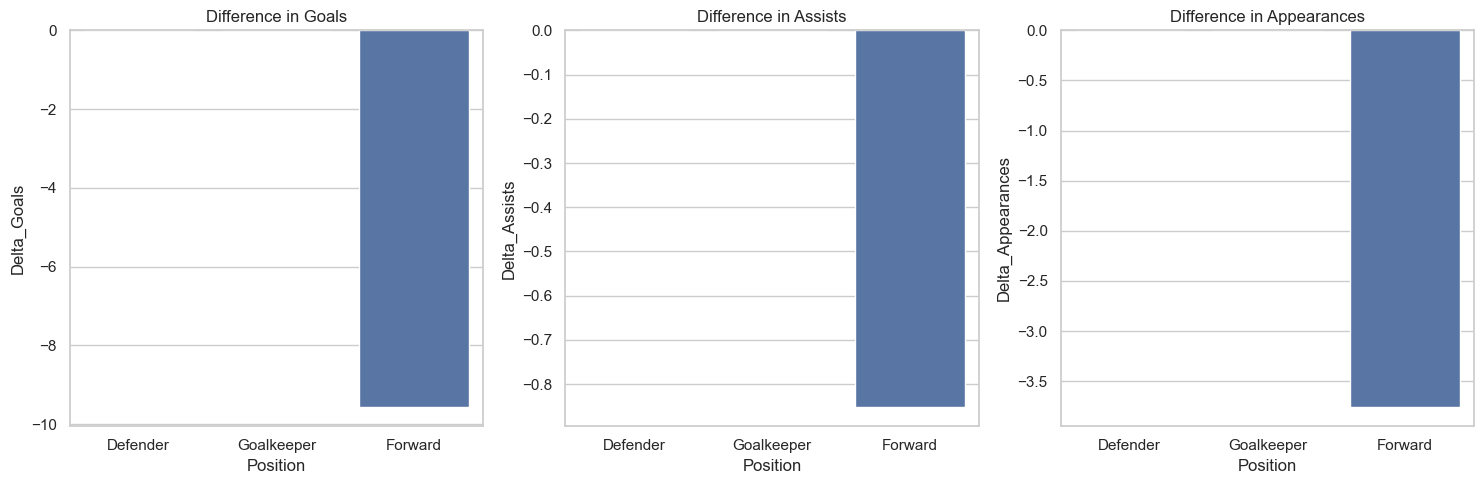

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

pandas_df = comparison_df.toPandas()

sns.set(style="whitegrid")

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.barplot(x='Position', y='Delta_Goals', data=pandas_df)
plt.title('Difference in Goals')

plt.subplot(1, 3, 2)
sns.barplot(x='Position', y='Delta_Assists', data=pandas_df)
plt.title('Difference in Assists')


plt.subplot(1, 3, 3)
sns.barplot(x='Position', y='Delta_Appearances', data=pandas_df)
plt.title('Difference in Appearances')

plt.tight_layout()
plt.show()


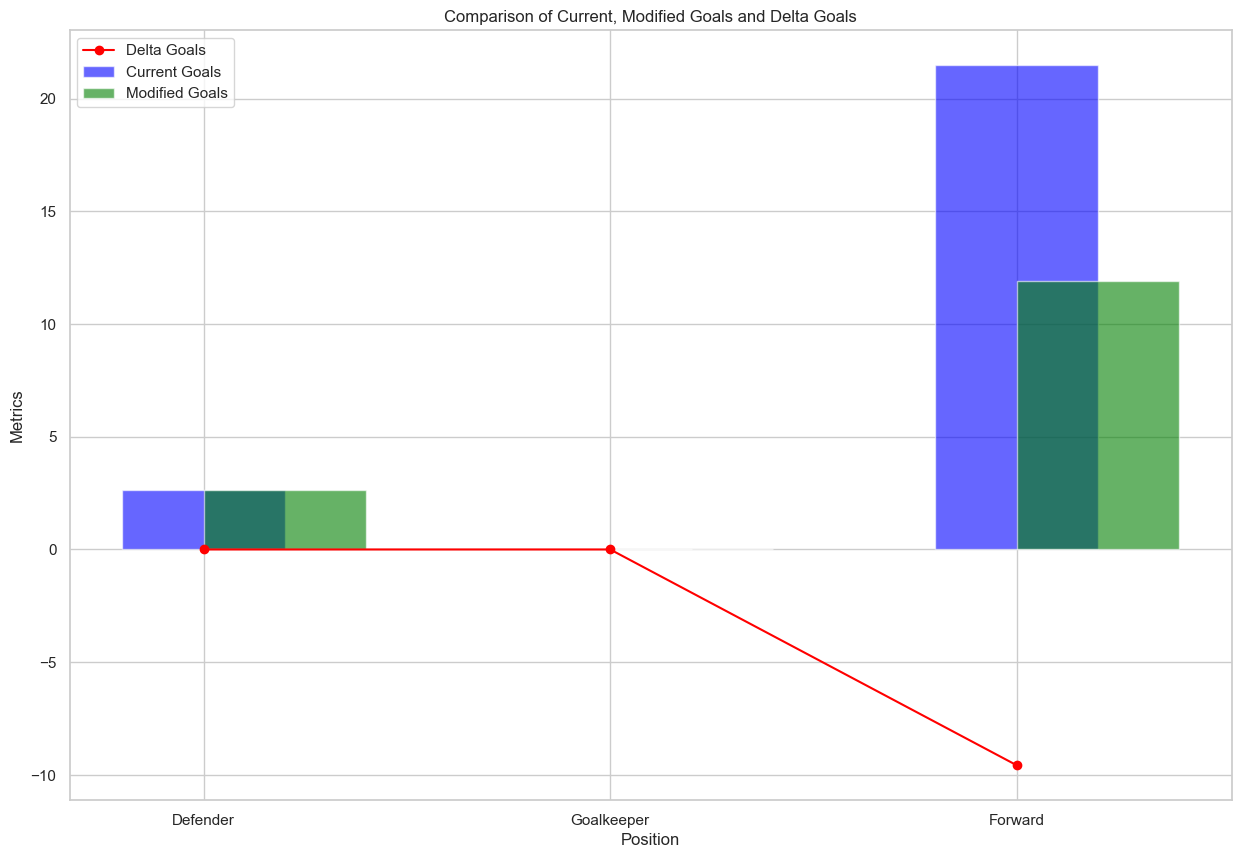

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

pandas_df = comparison_df.toPandas()

sns.set(style="whitegrid")

plt.figure(figsize=(15, 10))

plt.bar(pandas_df['Position'], pandas_df['Current_AverageGoals'], color='blue', label='Current Goals', alpha=0.6, width=0.4, align='center')
plt.bar(pandas_df['Position'], pandas_df['Modified_AverageGoals'], color='green', label='Modified Goals', alpha=0.6, width=0.4, align='edge')

plt.plot(pandas_df['Position'], pandas_df['Delta_Goals'], marker='o', label='Delta Goals', color='red')

plt.xlabel('Position')
plt.ylabel('Metrics')
plt.title('Comparison of Current, Modified Goals and Delta Goals')

plt.legend()

plt.show()


<h4>Analysis</h4>
The bar plots show the average goals in the current and modified scenarios side by side for each player position, making it easy to compare them directly.
The line plot overlays the change (delta) in goals, providing a clear visual indicator of how much the metric has increased or decreased.

<h1>Team Performance Evaluation<h1>

In [49]:
from pyspark.sql import functions as F
team_performance = df.groupBy("Club").agg(
    sum("Goals").alias("Total Goals"),
    sum("Assists").alias("Total Assists"),
    avg("Goals per match").alias("Average Goals per Match"),
    sum("Clean sheets").alias("Total Clean Sheets"),
    sum("Shots on target").alias("Total Shots on Target")
)



In [50]:
league_averages = df.agg(
    avg("Goals").alias("Average Goals"),
    avg("Assists").alias("Average Assists"),
    avg("Goals per match").alias("League Average Goals per Match"),
    avg("Clean sheets").alias("League Average Clean Sheets"),
    avg("Shots on target").alias("League Average Shots on Target")
)

In [51]:
league_averages_dict = league_averages.collect()[0].asDict()
for column, value in league_averages_dict.items():
    team_performance = team_performance.withColumn(column, F.lit(value))

In [52]:
team_performance.show()
league_averages.show()
#team_comparison.show()
#teams_to_improve.show()

+--------------------+-----------+-------------+-----------------------+------------------+---------------------+-----------------+-----------------+------------------------------+---------------------------+------------------------------+
|                Club|Total Goals|Total Assists|Average Goals per Match|Total Clean Sheets|Total Shots on Target|    Average Goals|  Average Assists|League Average Goals per Match|League Average Clean Sheets|League Average Shots on Target|
+--------------------+-----------+-------------+-----------------------+------------------+---------------------+-----------------+-----------------+------------------------------+---------------------------+------------------------------+
|   Manchester-United|        270|          209|     0.2535714285714286|               443|                  770|7.327495621716287|5.285464098073555|               2.6484142394822|          16.68702290076336|             36.91585760517799|
|   Tottenham-Hotspur|        387|      

Based on this analysis, you would develop strategic recommendations.
For instance, if a team's 'Total Goals' are significantly lower than the 'Average Goals', 
the recommendation might be to focus on improving attacking strategies or signing goal-scoring players.


In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

team_performance_pd = team_performance.toPandas()
league_averages_pd = league_averages.toPandas()


In [63]:
total_goals = team_performance_pd['Total Goals'].sum()  # Sum of all teams' goals
number_of_teams = team_performance_pd['Club'].nunique()  # Count of unique teams
league_average_goals = total_goals / number_of_teams

# Now you can use this correct league average goals in your analysis
print(f"League Average Goals: {league_average_goals}")

League Average Goals: 209.2


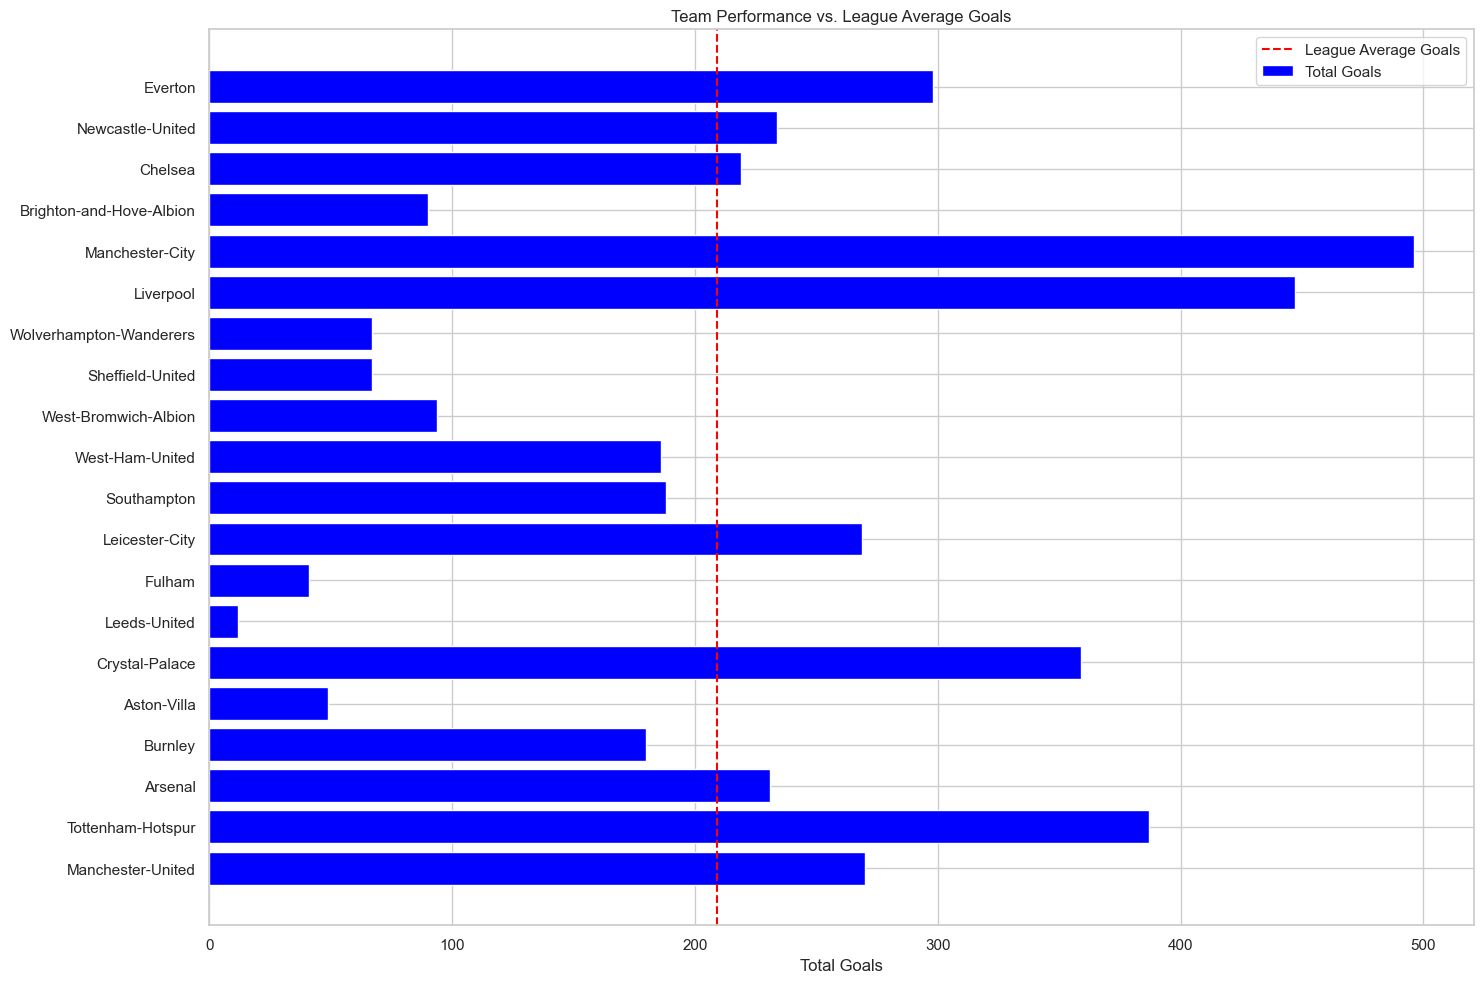

In [64]:
plt.figure(figsize=(15, 10))  # Adjust size for clarity
plt.barh(team_performance_pd['Club'], team_performance_pd['Total Goals'], color='blue', label='Total Goals')
plt.axvline(x=league_average_goals, color='red', linestyle='--', label='League Average Goals')

plt.xlabel('Total Goals')
plt.title('Team Performance vs. League Average Goals')
plt.legend()

plt.tight_layout()
plt.show()

Identifies which teams are outperforming or underperforming relative to league averages in metrics like goals and assists.
Highlights teams with exceptional performance either in scoring or in defensive records (like clean sheets).

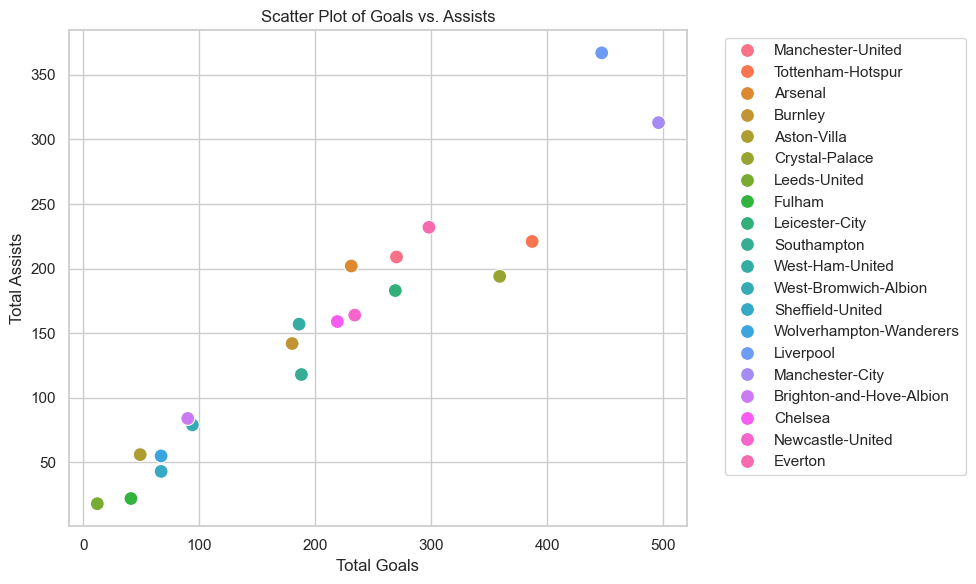

In [58]:
# Scatter Plot for Goals vs. Assists
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Total Goals', y='Total Assists', data=team_performance_pd, hue='Club', s=100)
plt.title('Scatter Plot of Goals vs. Assists')
plt.xlabel('Total Goals')
plt.ylabel('Total Assists')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Shows the relationship between scoring and assisting, indicating if teams with high goals also have high assists, which can point to strong offensive play.
Can help to identify outlier teams that have a high number of goals but low assists, or vice versa.

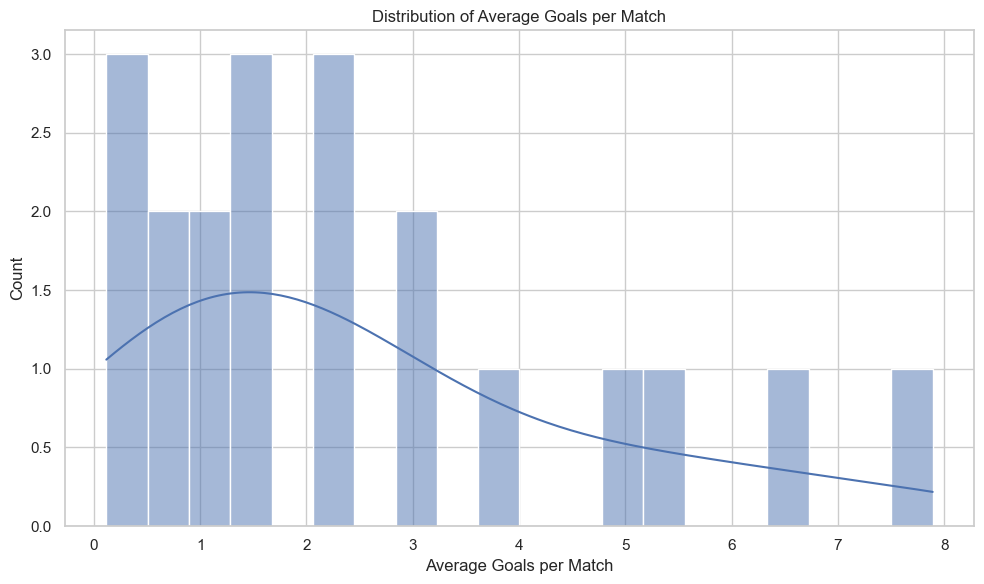

In [59]:
# Histogram for the Distribution of 'Average Goals per Match'
plt.figure(figsize=(10, 6))
sns.histplot(team_performance_pd['Average Goals per Match'], bins=20, kde=True)
plt.title('Distribution of Average Goals per Match')
plt.xlabel('Average Goals per Match')
plt.tight_layout()
plt.show()

Reveals the distribution of teams' scoring abilities per match, indicating whether the league is top-heavy (few teams scoring much higher than the rest) or if there's a balanced scoring distribution.
Identifies the common scoring rate and how many teams fall above or below this average.

In [67]:
import pandas as pd

league_averages = {
    'Average Goals': team_performance_pd['Total Goals'].mean(),
    'Average Assists': team_performance_pd['Total Assists'].mean(),
    'Average Clean Sheets': team_performance_pd['Total Clean Sheets'].mean(),
    'Average Shots on Target': team_performance_pd['Total Shots on Target'].mean()
}



In [68]:
recruitment_needs = {
    'Offensive Recruitment': team_performance_pd[team_performance_pd['Total Goals'] + team_performance_pd['Total Assists'] < league_averages['Average Goals'] + league_averages['Average Assists']],
    'Defensive Recruitment': team_performance_pd[team_performance_pd['Total Clean Sheets'] < league_averages['Average Clean Sheets']],
    'Attacking Recruitment': team_performance_pd[team_performance_pd['Total Shots on Target'] < league_averages['Average Shots on Target']]
}

In [69]:
print("Teams needing offensive recruitment (Low Goals and Assists):")
print(recruitment_needs['Offensive Recruitment']['Club'])

print("\nTeams needing defensive recruitment (Few Clean Sheets):")
print(recruitment_needs['Defensive Recruitment']['Club'])

print("\nTeams needing attacking recruitment (Low Shots on Target):")
print(recruitment_needs['Attacking Recruitment']['Club'])

Teams needing offensive recruitment (Low Goals and Assists):
3                      Burnley
4                  Aston-Villa
6                 Leeds-United
7                       Fulham
9                  Southampton
10             West-Ham-United
11        West-Bromwich-Albion
12            Sheffield-United
13     Wolverhampton-Wanderers
16    Brighton-and-Hove-Albion
Name: Club, dtype: object

Teams needing defensive recruitment (Few Clean Sheets):
4                  Aston-Villa
6                 Leeds-United
7                       Fulham
9                  Southampton
10             West-Ham-United
11        West-Bromwich-Albion
12            Sheffield-United
13     Wolverhampton-Wanderers
16    Brighton-and-Hove-Albion
18            Newcastle-United
Name: Club, dtype: object

Teams needing attacking recruitment (Low Shots on Target):
2                      Arsenal
3                      Burnley
4                  Aston-Villa
6                 Leeds-United
7                       Fu

In [85]:
teams_needing_offensive_recruitment = ['Burnley', 'Aston-Villa', 'Leeds-United']
teams_needing_defensive_recruitment = ['Aston-Villa', 'Leeds-United', 'Fulham']
teams_needing_attacking_recruitment = ['Arsenal', 'Burnley', 'Aston-Villa']

In [90]:
def recommend_players(player_data, teams_list, recruitment_type):
    recommendations = {}
    for team in teams_list:
        if recruitment_type == 'offensive':
            # Find top players not in the given team with high goals and assists
            top_players = player_data[(~player_data['Club'].isin(teams_list)) & 
                                      (player_data['Goals'] + player_data['Assists'] > 10)]  # Example criterion
        elif recruitment_type == 'defensive':
            # Find top defenders/goalkeepers from other teams with good defensive records
            top_players = player_data[(~player_data['Club'].isin(teams_list)) & 
                                      (player_data['Clean sheets'] > 5) & 
                                      (player_data['Position'].str.contains('Defender|Goalkeeper'))]
        elif recruitment_type == 'attacking':
            # Find top attackers from other teams with high shots on target
            top_players = player_data[(~player_data['Club'].isin(teams_list)) & 
                                      (player_data['Shots on target'] > 30)]


        relevant_columns = ['Name', 'Club', 'Goals', 'Assists', 'Clean sheets', 'Shots on target']
        recommendations[team] = top_players[relevant_columns].sort_values(by=['Goals', 'Assists'], ascending=False).head(5)

    return recommendations


In [92]:
offensive_recommendations = recommend_players(player_data, teams_needing_offensive_recruitment, 'offensive')

In [94]:
for team, recommendations in offensive_recommendations.items():
    print(f"{team} should consider recruiting the following players to enhance their offensive capabilities:")
    display(recommendations[['Name', 'Club', 'Goals', 'Assists', 'Shots on target']])
    print("\n")

Burnley should consider recruiting the following players to enhance their offensive capabilities:


,Name,Club,Goals,Assists,Shots on target
344,Sergio Agüero,Manchester-City,180,46,411.0
489,Harry Kane,Tottenham-Hotspur,144,24,354.0
281,Jamie Vardy,Leicester-City,105,29,223.0
342,Raheem Sterling,Manchester-City,86,45,222.0
313,Sadio Mané,Liverpool,86,29,190.0




Aston-Villa should consider recruiting the following players to enhance their offensive capabilities:


,Name,Club,Goals,Assists,Shots on target
344,Sergio Agüero,Manchester-City,180,46,411.0
489,Harry Kane,Tottenham-Hotspur,144,24,354.0
281,Jamie Vardy,Leicester-City,105,29,223.0
342,Raheem Sterling,Manchester-City,86,45,222.0
313,Sadio Mané,Liverpool,86,29,190.0




Leeds-United should consider recruiting the following players to enhance their offensive capabilities:


,Name,Club,Goals,Assists,Shots on target
344,Sergio Agüero,Manchester-City,180,46,411.0
489,Harry Kane,Tottenham-Hotspur,144,24,354.0
281,Jamie Vardy,Leicester-City,105,29,223.0
342,Raheem Sterling,Manchester-City,86,45,222.0
313,Sadio Mané,Liverpool,86,29,190.0


In [95]:
def recommend_players_for_role(player_data, teams_list, role):
    recommendations = {}
    for team in teams_list:
        if role == 'defensive':
            # Find top defenders not in the given team with good defensive stats
            top_defenders = player_data[(~player_data['Club'].isin(teams_list)) &
                                        (player_data['Position'].str.contains('Defender')) &
                                        (player_data['Clean sheets'] > 5) &  # Example criterion
                                        (player_data['Interceptions'] + player_data['Tackles'] > 50)]  # Adjust criteria as needed
            relevant_columns = ['Name', 'Club', 'Clean sheets', 'Interceptions', 'Tackles']
            recommendations[team] = top_defenders[relevant_columns].sort_values(by=['Clean sheets', 'Interceptions', 'Tackles'], ascending=False).head(5)

        elif role == 'midfield':
            # Find top midfielders not in the given team with good playmaking stats
            top_midfielders = player_data[(~player_data['Club'].isin(teams_list)) &
                                          (player_data['Position'].str.contains('Midfield')) &
                                          (player_data['Assists'] + player_data['Big chances created'] > 10)]  # Adjust criteria as needed
            relevant_columns = ['Name', 'Club', 'Assists', 'Passes', 'Big chances created']
            recommendations[team] = top_midfielders[relevant_columns].sort_values(by=['Assists', 'Big chances created'], ascending=False).head(5)

    return recommendations


In [98]:
teams_needing_defensive_recruitment = ['Aston-Villa', 'Leeds-United', 'Fulham']
teams_needing_midfield_recruitment = ['Burnley', 'Aston-Villa', 'Leeds-United']

defensive_recommendations = recommend_players_for_role(player_data, teams_needing_defensive_recruitment, 'defensive')
midfield_recommendations = recommend_players_for_role(player_data, teams_needing_midfield_recruitment, 'midfield')

In [99]:
print("Defensive Recruitment Recommendations:\n")
for team, players in defensive_recommendations.items():
    print(f"{team} should consider recruiting the following defenders:")
    display(players)
    print("\n")

Defensive Recruitment Recommendations:

Aston-Villa should consider recruiting the following defenders:


,Name,Club,Clean sheets,Interceptions,Tackles
419,Phil Jagielka,Sheffield-United,107.0,618.0,703.0
324,Kyle Walker,Manchester-City,99.0,498.0,600.0
151,Gary Cahill,Crystal-Palace,99.0,452.0,471.0
122,César Azpilicueta,Chelsea,95.0,475.0,722.0
504,Branislav Ivanovic,West-Bromwich-Albion,86.0,393.0,528.0




Leeds-United should consider recruiting the following defenders:


,Name,Club,Clean sheets,Interceptions,Tackles
419,Phil Jagielka,Sheffield-United,107.0,618.0,703.0
324,Kyle Walker,Manchester-City,99.0,498.0,600.0
151,Gary Cahill,Crystal-Palace,99.0,452.0,471.0
122,César Azpilicueta,Chelsea,95.0,475.0,722.0
504,Branislav Ivanovic,West-Bromwich-Albion,86.0,393.0,528.0




Fulham should consider recruiting the following defenders:


,Name,Club,Clean sheets,Interceptions,Tackles
419,Phil Jagielka,Sheffield-United,107.0,618.0,703.0
324,Kyle Walker,Manchester-City,99.0,498.0,600.0
151,Gary Cahill,Crystal-Palace,99.0,452.0,471.0
122,César Azpilicueta,Chelsea,95.0,475.0,722.0
504,Branislav Ivanovic,West-Bromwich-Albion,86.0,393.0,528.0


In [100]:
print("Midfield Recruitment Recommendations:\n")
for team, players in midfield_recommendations.items():
    print(f"{team} should consider recruiting the following midfielders:")
    display(players)
    print("\n")

Midfield Recruitment Recommendations:

Burnley should consider recruiting the following midfielders:


,Name,Club,Assists,Passes,Big chances created
302,James Milner,Liverpool,84,16171,46.0
335,Kevin De Bruyne,Manchester-City,67,8407,97.0
13,Mesut Özil,Arsenal,54,11186,65.0
365,Juan Mata,Manchester-United,52,11379,68.0
304,Jordan Henderson,Liverpool,46,17932,49.0




Aston-Villa should consider recruiting the following midfielders:


,Name,Club,Assists,Passes,Big chances created
302,James Milner,Liverpool,84,16171,46.0
335,Kevin De Bruyne,Manchester-City,67,8407,97.0
13,Mesut Özil,Arsenal,54,11186,65.0
365,Juan Mata,Manchester-United,52,11379,68.0
304,Jordan Henderson,Liverpool,46,17932,49.0




Leeds-United should consider recruiting the following midfielders:


,Name,Club,Assists,Passes,Big chances created
302,James Milner,Liverpool,84,16171,46.0
335,Kevin De Bruyne,Manchester-City,67,8407,97.0
13,Mesut Özil,Arsenal,54,11186,65.0
365,Juan Mata,Manchester-United,52,11379,68.0
304,Jordan Henderson,Liverpool,46,17932,49.0


In [143]:
from pyspark.sql.functions import desc

younger_players = df.filter(df.Age < 22)

top_young_attacker = younger_players.filter(df.Position == 'Forward').orderBy(
    desc("Goals"), 
    desc("Goals per match"), 
    desc("Shooting accuracy %"), 
    desc("Shots"), 
    desc("Shots on target")
).first()

top_young_defender = younger_players.filter(df.Position == 'Defender').orderBy(
    desc("Clean sheets"), 
    desc("Tackles"), 
    desc("Tackle success %"), 
    desc("Last man tackles"), 
    desc("Blocked shots"), 
    desc("Clearances"), 
    desc("Headed Clearance"), 
    desc("Clearances off line")
).first()

top_young_midfielder = younger_players.filter(df.Position == 'Midfielder').orderBy(
    desc("Assists"), 
    desc("Passes"), 
    desc("Passes per match"), 
    desc("Big chances created")
).first()


In [144]:
if top_young_attacker:
    print("Top Young Attacker (Under 20):")
    print(f"Name: {top_young_attacker['Name']}, Club: {top_young_attacker['Club']}, Goals: {top_young_attacker['Goals']}")
else:
    print("No top young attacker found under age 20.")


if top_young_defender:
    print("\nTop Young Defender (Under 20):")
    print(f"Name: {top_young_defender['Name']}, Club: {top_young_defender['Club']}, Clean Sheets: {top_young_defender['Clean sheets']}")
else:
    print("No top young defender found under age 20.")

if top_young_midfielder:
    print("\nTop Young Midfielder (Under 20):")
    print(f"Name: {top_young_midfielder['Name']}, Club: {top_young_midfielder['Club']}, Assists: {top_young_midfielder['Assists']}")
else:
    print("No top young midfielder found under age 20.")


Top Young Attacker (Under 20):
Name: Mason Greenwood, Club: Manchester-United, Goals: 10

Top Young Defender (Under 20):
Name: Trent Alexander-Arnold, Club: Liverpool, Clean Sheets: 31

Top Young Midfielder (Under 20):
Name: Dwight McNeil, Club: Burnley, Assists: 12


In [141]:

prime_age_players = df.filter((df.Age >= 20) & (df.Age <= 33))

top_attacker = prime_age_players.filter(df.Position == 'Forward').orderBy(
    desc("Goals"),
    desc("Goals per match"),
    desc("Shooting accuracy %"),
    desc("Shots"),
    desc("Shots on target")
).first()


top_defender = prime_age_players.filter(df.Position == 'Defender').orderBy(
    desc("Clean sheets"),
    desc("Tackles"),
    desc("Tackle success %"),
    desc("Last man tackles"),
    desc("Blocked shots"),
    desc("Clearances"),
    desc("Headed Clearance"),
    desc("Clearances off line")
).first()

top_midfielder = prime_age_players.filter(df.Position == 'Midfielder').orderBy(
    desc("Assists"),
    desc("Passes"),
    desc("Passes per match"),
    desc("Big chances created")
).first()



In [142]:
# Check and print details for the top attacker
if top_attacker:
    print("Top Attacker (Age 20-33):")
    print(f"Name: {top_attacker['Name']}, Club: {top_attacker['Club']}, Goals: {top_attacker['Goals']}")
else:
    print("No top attacker found in the age range 20-33.")

# Check and print details for the top defender
if top_defender:
    print("\nTop Defender (Age 20-33):")
    print(f"Name: {top_defender['Name']}, Club: {top_defender['Club']}, Clean Sheets: {top_defender['Clean sheets']}")
else:
    print("No top defender found in the age range 20-33.")

# Check and print details for the top midfielder
if top_midfielder:
    print("\nTop Midfielder (Age 20-33):")
    print(f"Name: {top_midfielder['Name']}, Club: {top_midfielder['Club']}, Assists: {top_midfielder['Assists']}")
else:
    print("No top midfielder found in the age range 20-33.")


Top Attacker (Age 20-33):
Name: Sergio Agüero, Club: Manchester-City, Goals: 180

Top Defender (Age 20-33):
Name: Kyle Walker, Club: Manchester-City, Clean Sheets: 99

Top Midfielder (Age 20-33):
Name: Kevin De Bruyne, Club: Manchester-City, Assists: 67
